In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
from sklearn.metrics import confusion_matrix, mean_squared_error
import os
import pickle
import time
from itertools import chain, combinations
from collections import Counter
from Graphs import matrix_to_graph, graph_to_matrix, ErdosRenyiGraph, dRegularGraph
from ShortestDistanceAlgorithms import shortestDistance_allNodes_networkx, shortestDistance_allNodes_Bourgain, shortestDistance_allNodes_Sarma, onlineShortestPath_Bourgain, onlineShortestPath_Sarma
from Models import build

In [2]:
def generateSamples_inner(num_graphs,function,*args,**kwargs):

    #largest_component_sizes = []
    #lbds = []

    samples_x = []
    samples_y_actual = []
    samples_y_Bourgain = []
    samples_y_Sarma1 = []
    samples_y_Sarma2 = []
    samples_y_Sarma3 = []
    #samples_y_Sarma4 = []
    samples_edge_index = []
    samples_weights = []

    #max_lbd = getLambda(n)
    k = 0
    n_rejected1 = 0
    n_rejected2 = 0
    while k < num_graphs:
        try:
            G,directed,weighted = function(*args,**kwargs)
            n = len(G.nodes())
            r = int(np.floor(np.sqrt(n)))
            largest_component = max(nx.strongly_connected_components(G), key=len)
            n_nodes = len(largest_component)
            if n_nodes >= max(r,10):
                #largest_component_sizes.append(n_nodes)
                #lbds.append(lbd)
                G = G.subgraph(largest_component)
                G = nx.relabel_nodes(G, {node: index for index, node in enumerate(G.nodes())})
                matrix = graph_to_matrix(G)
                seeds = np.random.choice(range(n_nodes),size=r,replace=False)
                x = np.zeros((n_nodes,r))
                y_actual = np.zeros((n_nodes,r))
                y_Bourgain = np.zeros((n_nodes,r))
                y_Sarma1 = np.zeros((n_nodes,r))
                y_Sarma2 = np.zeros((n_nodes,r))
                y_Sarma3 = np.zeros((n_nodes,r))
                #y_Sarma4 = np.zeros((n_nodes,r))
                M = n_nodes
                for i in range(r):
                    u = seeds[i]
                    #support = [n for n in range(matrix.shape[0]) if np.count_nonzero(matrix[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
                    #print(support)
                    x[u,i] = 1
                    y_actual[:,i] = shortestDistance_allNodes_networkx(G,u)
                    if n <= N:
                        y_Bourgain[:,i] = shortestDistance_allNodes_Bourgain(matrix,u)
                        y_Sarma1[:,i] = shortestDistance_allNodes_Sarma(matrix,u,1)
                        y_Sarma2[:,i] = shortestDistance_allNodes_Sarma(matrix,u,2)
                        y_Sarma3[:,i] = shortestDistance_allNodes_Sarma(matrix,u,3)
                    #y_Sarma4[:,i] = shortestDistance_allNodes_Bourgain(matrix,u,4)
                    #y_Sarma4 = np.where(y_Sarma4 == float('inf'), M, y_Sarma4)
                if n <= N:
                    y_Bourgain = np.where(y_Bourgain == float('inf'), M, y_Bourgain)
                    y_Sarma1 = np.where(y_Sarma1 == float('inf'), M, y_Sarma1)
                    y_Sarma2 = np.where(y_Sarma2 == float('inf'), M, y_Sarma2)
                    y_Sarma3 = np.where(y_Sarma3 == float('inf'), M, y_Sarma3)
                samples_x.append(torch.tensor(x.astype(np.float32), requires_grad=True))
                samples_y_actual.append(torch.tensor(y_actual).to(torch.float32))
                samples_y_Bourgain.append(y_Bourgain)
                samples_y_Sarma1.append(y_Sarma1)
                samples_y_Sarma2.append(y_Sarma2)
                samples_y_Sarma3.append(y_Sarma3)
                samples_edge_index.append(torch.tensor(np.array(list(G.edges())).T).to(torch.int64))
                if weighted: 
                    samples_weights.append(torch.tensor(nx.get_edge_attributes(G,'weight').values()).to(torch.float32))
                k += 1
            else:
                n_rejected2 += 1
        except:
            n_rejected1 += 1
        if n_rejected1 + n_rejected2 >= 10000:
            raise ValueError(
                'Possibly stuck in an infinite loop.'
            )
    
    print('Number of graphs rejected because Bourgain\'s and Sarma\'s algorithms yield errors: ',n_rejected1)
    print('Number of graphs rejected because the largest component has insufficient size: ',n_rejected2)

    return samples_x, [samples_y_actual, samples_y_Bourgain, samples_y_Sarma1, samples_y_Sarma2, samples_y_Sarma3], samples_edge_index, samples_weights

def generateSamples(n_train,n_val,n_test,function,*args,**kwargs):
    print('Generating training data...')
    train = generateSamples_inner(n_train,function,*args,**kwargs)
    print('Generating validation data...')
    val = generateSamples_inner(n_val,function,*args,**kwargs)
    print('Generating test data...')
    test = generateSamples_inner(n_test,function,*args,**kwargs)
    return [train, val, test]

In [5]:
def evaluate_inner(n,data_name,y,y_pred1,y_pred2):

    y_pred1 = np.array(list(chain(*[np.ravel(arr) for arr in y_pred1])))
    y_pred2 = np.array(list(chain(*[np.ravel(arr) for arr in y_pred2])))
    y_actual = np.array(list(chain(*[np.ravel(arr) for arr in y[0]])))
    diff_pred1 = y_actual - y_pred1
    diff_pred2 = y_actual - y_pred2

    values, base = np.histogram(diff_pred1, bins=100)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1], cumulative, label='GNN, out_channels = floor(sqrt(n))', alpha = 0.75)
    
    values, base = np.histogram(diff_pred2, bins=100)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1], cumulative, label='GNN, out_channels = 1', alpha = 0.75)

    if n <= N:

        y_Bourgain = np.array(list(chain(*[np.ravel(arr) for arr in y[1]])))
        y_Sarma1 = np.array(list(chain(*[np.ravel(arr) for arr in y[2]])))
        y_Sarma2 = np.array(list(chain(*[np.ravel(arr) for arr in y[3]])))
        y_Sarma3 = np.array(list(chain(*[np.ravel(arr) for arr in y[4]])))
        diff_Bourgain = y_actual-y_Bourgain
        diff_Sarma1 = y_actual-y_Sarma1
        diff_Sarma2 = y_actual-y_Sarma2
        diff_Sarma3 = y_actual-y_Sarma3

        values, base = np.histogram(diff_Bourgain, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Bourgain', alpha = 0.75)

        values, base = np.histogram(diff_Sarma1, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 1', alpha = 0.75)

        values, base = np.histogram(diff_Sarma2, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 2', alpha = 0.75)

        values, base = np.histogram(diff_Sarma3, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 3', alpha = 0.75)

    plt.xlabel('Actual Distance - Predicted Distance')
    plt.ylabel('Cummulative Frequency')
    plt.title(data_name+', n = '+str(n)+', lambda = '+str(lbd))
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

    plt.scatter(y_actual, y_pred1, label='GNN, out_channels = floor(sqrt(n))', alpha = 0.1)
    plt.scatter(y_actual, y_pred2, label='GNN, out_channels = 1', alpha = 0.1)
    plt.xlabel('Actual Distance')
    plt.ylabel('Predicted Distance')
    plt.title(data_name+', n = '+str(n)+', lambda = '+str(lbd))
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

    plt.hist(y_actual, edgecolor='white', alpha=0.4)
    #sns.kdeplot(y_actual, fill=True, alpha=0.2)
    plt.xlabel('Actual Distance')
    plt.ylabel('Density')
    plt.title(data_name+', n = '+str(n)+', lambda = '+str(lbd))
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

    return diff_pred1
    
def evaluate(n,model1,model2,criterion_type,samples):
    y_pred_train1,y_pred_val1,y_pred_test1 = predict_allBatches(model1,criterion_type,samples)
    y_pred_train2,y_pred_val2,y_pred_test2 = predict_allBatches(model2,criterion_type,samples) 
    diff_pred_train = evaluate_inner(n,'Training Data',samples[0][1],y_pred_train1,y_pred_train2)
    diff_pred_val = evaluate_inner(n,'Validation Data',samples[1][1],y_pred_val1,y_pred_val2)
    diff_pred_test = evaluate_inner(n,'Test Data',samples[2][1],y_pred_test1,y_pred_test2)

    sns.kdeplot(diff_pred_train, fill=True, label='Training Data', alpha=0.2)
    sns.kdeplot(diff_pred_val, fill=True, label='Validation Data', alpha=0.2)
    sns.kdeplot(diff_pred_test, fill=True, label='Test Data', alpha=0.2)

    plt.xlabel('Actual Distance - Predicted Distance')
    plt.ylabel('Density')
    plt.title('n = '+str(n)+', lambda = '+str(lbd))
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

In [8]:
def generate_one_graph_all_distances(function,*args,**kwargs):

    n_rejected1 = 0
    n_rejected2 = 0
    while True:
        #print(1)
        try:
            G,directed,weighted = function(*args,**kwargs)
            n = len(G.nodes())
            r = int(np.floor(np.sqrt(n)))
            components = list(nx.strongly_connected_components(G))
            largest_component = max(components, key=len)
            n_nodes = len(largest_component)
            #print(n_nodes)
            if n_nodes >= max(r,10):
                G = G.subgraph(largest_component)
                G = nx.relabel_nodes(G, {node: index for index, node in enumerate(G.nodes())})
                matrix = graph_to_matrix(G)
                y_actual_all = np.zeros((n_nodes,n_nodes))
                if n <= N:
                    y_Bourgain_all = np.zeros((n_nodes,n_nodes))
                    y_Sarma1_all = np.zeros((n_nodes,n_nodes))
                    y_Sarma2_all = np.zeros((n_nodes,n_nodes))
                    y_Sarma3_all = np.zeros((n_nodes,n_nodes))
                M = n_nodes

                samples_x = [torch.tensor(np.eye(n_nodes).astype(np.float32), requires_grad=True)]
                samples_edge_index = [torch.tensor(np.array(list(G.edges())).T).to(torch.int64)]
                if weighted:
                    samples_weights = [torch.tensor(nx.get_edge_attributes(G,'weight').values()).to(torch.float32)]
                else:
                    samples_weights = []

                if directed:
                    start_time = time.time()
                    for i in range(n_nodes):
                        y_actual_all[:,i] = shortestDistance_allNodes_networkx(G,i)
                    end_time = time.time()
                else:
                    if 'weight' in G.graph:
                        start_time = time.time()
                        for i in range(n_nodes):
                            for v in range(i+1,n_nodes):
                                y_actual_all[v,i] = nx.shortest_path_length(G, i, v, weight='weight')
                                y_actual_all[i,v] = y_actual_all[v,i]
                        end_time = time.time()
                    else:
                        start_time = time.time()
                        for i in range(n_nodes):
                            for v in range(i+1,n_nodes):
                                y_actual_all[v,i] = nx.shortest_path_length(G, i, v)
                                y_actual_all[i,v] = y_actual_all[v,i]
                        end_time = time.time()
                dur_networkx = end_time - start_time
                samples_y_actual = [torch.tensor(y_actual_all).to(torch.float32)]

                dur_Bourgain = -1
                dur_Sarma1 = -1
                dur_Sarma2 = -1
                dur_Sarma3 = -1

                if n <= N:

                    if directed:
                
                        start_time = time.time()
                        for i in range(n_nodes):
                            y_Bourgain_all[:,i] = shortestDistance_allNodes_Bourgain(matrix,i)
                        y_Bourgain_all = np.where(y_Bourgain_all == float('inf'), M, y_Bourgain_all)
                        end_time = time.time()
                        dur_Bourgain = end_time - start_time

                        start_time = time.time()
                        for i in range(n_nodes):
                            y_Sarma1_all[:,i] = shortestDistance_allNodes_Sarma(matrix,i,1)
                        y_Sarma1_all = np.where(y_Sarma1_all == float('inf'), M, y_Sarma1_all)
                        end_time = time.time()
                        dur_Sarma1 = end_time - start_time

                        start_time = time.time()
                        for i in range(n_nodes):
                            y_Sarma2_all[:,i] = shortestDistance_allNodes_Sarma(matrix,i,2)
                        y_Sarma2_all = np.where(y_Sarma2_all == float('inf'), M, y_Sarma2_all)
                        end_time = time.time()
                        dur_Sarma2 = end_time - start_time

                        start_time = time.time()
                        for i in range(n_nodes):
                            y_Sarma3_all[:,i] = shortestDistance_allNodes_Sarma(matrix,i,3)
                        y_Sarma3_all = np.where(y_Sarma3_all == float('inf'), M, y_Sarma3_all)
                        end_time = time.time()
                        dur_Sarma3 = end_time - start_time

                    else:
                        
                        start_time = time.time()
                        for i in range(n_nodes):
                            for v in range(i+1,n_nodes):
                                y_Bourgain_all[v,i] = onlineShortestPath_Bourgain(matrix,i,v,directed)
                                y_Bourgain_all[i,v] = y_Bourgain_all[v,i]
                        y_Bourgain_all = np.where(y_Bourgain_all == float('inf'), M, y_Bourgain_all)
                        end_time = time.time()
                        dur_Bourgain = end_time - start_time

                        start_time = time.time()
                        for i in range(n_nodes):
                            for v in range(i+1,n_nodes):        
                                y_Sarma1_all[v,i] = onlineShortestPath_Sarma(matrix,i,v,1,directed)
                                y_Sarma1_all[i,v] = y_Sarma1_all[v,i]
                        y_Sarma1_all = np.where(y_Sarma1_all == float('inf'), M, y_Sarma1_all)
                        end_time = time.time()
                        dur_Sarma1 = end_time - start_time

                        start_time = time.time()
                        for i in range(n_nodes):
                            for v in range(i+1,n_nodes):        
                                y_Sarma2_all[v,i] = onlineShortestPath_Sarma(matrix,i,v,2,directed)
                                y_Sarma2_all[i,v] = y_Sarma2_all[v,i]
                        y_Sarma2_all = np.where(y_Sarma2_all == float('inf'), M, y_Sarma2_all)
                        end_time = time.time()
                        dur_Sarma2 = end_time - start_time

                        start_time = time.time()
                        for i in range(n_nodes):
                            for v in range(i+1,n_nodes):        
                                y_Sarma3_all[v,i] = onlineShortestPath_Sarma(matrix,i,v,3,directed)
                                y_Sarma3_all[i,v] = y_Sarma3_all[v,i]            
                        y_Sarma3_all = np.where(y_Sarma3_all == float('inf'), M, y_Sarma3_all)
                        end_time = time.time()
                        dur_Sarma3 = end_time - start_time
                    
                    samples_y_Bourgain = [y_Bourgain_all]
                    samples_y_Sarma1 = [y_Sarma1_all]
                    samples_y_Sarma2 = [y_Sarma2_all]
                    samples_y_Sarma3 = [y_Sarma3_all]

                else:
                    samples_y_Bourgain = []
                    samples_y_Sarma1 = []
                    samples_y_Sarma2 = []
                    samples_y_Sarma3 = []

                break
            else:
                n_rejected2 += 1
        except:
            n_rejected1 += 1
        if n_rejected1 + n_rejected2 >= 100000:
            raise ValueError(
                'Possibly stuck in an infinite loop.'
            )
    
    # if print_summary:
    #     print('Number of graphs rejected because Bourgain\'s and Sarma\'s algorithms yield errors: ',n_rejected1)
    #     print('Number of graphs rejected because the largest component has insufficient size: ',n_rejected2)

    return samples_x, [(samples_y_actual,dur_networkx), (samples_y_Bourgain,dur_Bourgain), (samples_y_Sarma1,dur_Sarma1), (samples_y_Sarma2,dur_Sarma2), (samples_y_Sarma3,dur_Sarma3)], samples_edge_index, samples_weights

def evaluate_one_graph_all_distances(n,model1,model2,criterion_type,sample,display_results = False):

    gpu_bool = torch.cuda.is_available()
    r = model1.out_channels

    start_time = time.time()
    y_pred2 = predict(gpu_bool, model2, criterion_type, sample[0], sample[2], sample[3])[0]
    end_time = time.time()
    dur_GNN2 = end_time - start_time
    label2 = 'GNN, out_channels = 1'
    
    start_time = time.time()
    samples_x = []
    n_nodes = sample[0][0].shape[0]
    if n_nodes % r != 0:
        n_extra = int(np.ceil(n_nodes/r))*r - n_nodes
        # shuffled_nodes = np.random.permutation(range(n_nodes))
        # extra_seeds = shuffled_nodes[:n_extra]
        # shuffled_nodes = list(shuffled_nodes)+list(extra_seeds)
        nodes = list(range(n_nodes))+list(range(n_nodes)[:n_extra])
    else:
        #shuffled_nodes = np.random.permutation(range(n_nodes))
        nodes = list(range(n_nodes))
    #list_of_seeds = [shuffled_nodes[i:i + r] for i in range(0, len(shuffled_nodes), r)]
    list_of_seeds = [nodes[i:i + r] for i in range(0, len(nodes), r)]
    for seeds in list_of_seeds:
        x = np.zeros((n_nodes,r))
        for i in range(r):
            x[seeds[i],i] = 1
        samples_x.append(torch.tensor(x.astype(np.float32), requires_grad=True))
    y_pred1 = predict(gpu_bool, model1, criterion_type, samples_x, sample[2], sample[3])
    y_pred1 = np.concatenate(y_pred1, axis=1)[:,n_nodes]
    end_time = time.time()
    dur_GNN1 = end_time - start_time
    label1 = 'GNN, out_channels = floor(sqrt(n))'
   
    y_pred1 = np.array(list(chain(*[np.ravel(arr) for arr in y_pred1])))
    y_pred2 = np.array(list(chain(*[np.ravel(arr) for arr in y_pred2])))
    samples_y_actual = sample[1][0][0]
    y_actual = np.array(list(chain(*[np.ravel(arr) for arr in samples_y_actual])))
    mseGNN1 = mean_squared_error(y_actual, y_pred1)
    mseGNN2 = mean_squared_error(y_actual, y_pred2)
    if n <= N:
        samples_y_Bourgain = sample[1][1][0]
        samples_y_Sarma1 = sample[1][2][0]
        samples_y_Sarma2 = sample[1][3][0]
        samples_y_Sarma3 = sample[1][4][0]
        y_Bourgain = np.array(list(chain(*[np.ravel(arr) for arr in samples_y_Bourgain])))
        y_Sarma1 = np.array(list(chain(*[np.ravel(arr) for arr in samples_y_Sarma1])))
        y_Sarma2 = np.array(list(chain(*[np.ravel(arr) for arr in samples_y_Sarma2])))
        y_Sarma3 = np.array(list(chain(*[np.ravel(arr) for arr in samples_y_Sarma3])))
        mseBourgain = mean_squared_error(y_actual, y_Bourgain)
        mseSarma1 = mean_squared_error(y_actual, y_Sarma1)
        mseSarma2 = mean_squared_error(y_actual, y_Sarma2)
        mseSarma3 = mean_squared_error(y_actual, y_Sarma3)
    
    dur = [dur_GNN1,dur_GNN2,sample[1][1][1],sample[1][2][1],sample[1][3][1],sample[1][4][1]]

    if display_results:

        diff_pred1 = y_actual - y_pred1
        values, base = np.histogram(diff_pred1, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label=label1, alpha = 0.75)

        diff_pred2 = y_actual - y_pred2
        values, base = np.histogram(diff_pred2, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label=label2, alpha = 0.75)

        if n <= N:

            diff_Bourgain = y_actual-y_Bourgain
            values, base = np.histogram(diff_Bourgain, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Bourgain', alpha = 0.75)

            diff_Sarma1 = y_actual-y_Sarma1
            values, base = np.histogram(diff_Sarma1, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Sarma, k = 1', alpha = 0.75)

            diff_Sarma2 = y_actual-y_Sarma2
            values, base = np.histogram(diff_Sarma2, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Sarma, k = 2', alpha = 0.75)

            diff_Sarma3 = y_actual-y_Sarma3
            values, base = np.histogram(diff_Sarma3, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Sarma, k = 3', alpha = 0.75)
            
        plt.xlabel('Actual Distance - Predicted Distance')
        plt.ylabel('Cummulative Frequency')
        plt.title('All Distances: n = '+str(n)+', lambda = '+str(lbd))
        plt.legend()
        filenames = os.listdir(dir)
        if '0.png' not in filenames:
            plt.savefig(dir+'/0.png')
        else:
            filenames = sorted([int(f[:-4]) for f in filenames])
            plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
        plt.show()

        plt.scatter(y_actual, y_pred1, label=label1, alpha = 0.1)
        plt.scatter(y_actual, y_pred2, label=label2, alpha = 0.1)
        plt.xlabel('Actual Distance')
        plt.ylabel('Predicted Distance')
        plt.title('All Distances: n = '+str(n)+', lambda = '+str(lbd))
        filenames = os.listdir(dir)
        if '0.png' not in filenames:
            plt.savefig(dir+'/0.png')
        else:
            filenames = sorted([int(f[:-4]) for f in filenames])
            plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
        plt.show()

        plt.hist(y_actual, edgecolor='white', alpha=0.4)
        #sns.kdeplot(y_actual, fill=True, alpha=0.2)
        plt.xlabel('Actual Distance')
        plt.ylabel('Density')
        plt.title('All Distances: n = '+str(n)+', lambda = '+str(lbd))
        filenames = os.listdir(dir)
        if '0.png' not in filenames:
            plt.savefig(dir+'/0.png')
        else:
            filenames = sorted([int(f[:-4]) for f in filenames])
            plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
        plt.show()

        #plt.hist(diff_pred, edgecolor='white', alpha=0.4)
        sns.kdeplot(diff_pred1, label=label1, fill=True, alpha=0.2)
        sns.kdeplot(diff_pred2, label=label2, fill=True, alpha=0.2)
        plt.xlabel('Actual Distance - Predicted Distance')
        plt.ylabel('Density')
        plt.title('All Distances: n = '+str(n)+', lambda = '+str(lbd))
        filenames = os.listdir(dir)
        if '0.png' not in filenames:
            plt.savefig(dir+'/0.png')
        else:
            filenames = sorted([int(f[:-4]) for f in filenames])
            plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
        plt.show()

        print(label1+', MSE:',mseGNN1)
        print(label1+', runtime:',dur_GNN1)
        print(label2+', MSE:',mseGNN2)
        print(label2+', runtime:',dur_GNN2)
        if n <= N:
            print('Bourgain, MSE:',mseBourgain)
            print('Bourgain, runtime:',dur[1])
            print('Sarma, k = 1, MSE:',mseSarma1)
            print('Sarma, k = 1, runtime:',dur[2])
            print('Sarma, k = 2, MSE:',mseSarma2)
            print('Sarma, k = 2, runtime:',dur[3])
            print('Sarma, k = 3, MSE:',mseSarma3)
            print('Sarma, k = 3, runtime:',dur[4])

    if n <= N:
        return [mseGNN1,mseGNN2,mseBourgain,mseSarma1,mseSarma2,mseSarma3],dur
    else:
        return [mseGNN1,mseGNN2,-1,-1,-1,-1],dur

In [9]:
def generate_one_graph(function,*args,**kwargs):

    n_rejected1 = 0
    n_rejected2 = 0
    while True:
        try:
            G,directed,weighted = function(*args,**kwargs)
            n = len(G.nodes())
            #print(nx.number_strongly_connected_components(G))
            #components = list(nx.strongly_connected_components(G))
            largest_component = max(nx.strongly_connected_components(G), key=len)
            n_nodes = len(largest_component)
            #print(n_nodes)
            r = int(np.floor(np.sqrt(n)))
            if n_nodes >= max(r,10):
                G = G.subgraph(largest_component)
                G = nx.relabel_nodes(G, {node: index for index, node in enumerate(G.nodes())})
                break
            else:
                n_rejected2 += 1
        except:
            n_rejected1 += 1
        if n_rejected1 + n_rejected2 >= 10000:
            raise ValueError(
                'Possibly stuck in an infinite loop.'
            )
    
    # if print_summary:
    #     print('Number of graphs rejected because Bourgain\'s and Sarma\'s algorithms yield errors: ',n_rejected1)
    #     print('Number of graphs rejected because the largest component has insufficient size: ',n_rejected2)

    return G,directed,weighted

def evaluate_one_graph_random_distances(alpha,n,model1,model2,criterion_type,graph_info,display_results = False):
    
    graph = graph_info[0]
    matrix = graph_to_matrix(graph)
    directed = graph_info[1]
    weighted = graph_info[2]

    n_nodes = len(graph.nodes())
    n_pairs = (n_nodes*(n_nodes-1)/2)**(1/alpha)
    k = 0
    nodes = range(n_nodes)
    pairs = []
    pairs_dump = []
    while k <= n_pairs:
        pair = tuple(np.random.choice(nodes,size=2,replace=False))
        if pair not in pairs:
            pairs.append(pair)
            pairs_dump.append(pair)
            k += 1
    
    if directed:
        seeds = list(set(np.array(pairs_dump)[:,0]))
    else:
        seeds = []
        while len(pairs_dump) > 0:
            #print(pairs_dump)
            flattened = list(chain(*pairs_dump))
            most_frequent_item = Counter(flattened).most_common(flattened[-1])
            seeds.append(most_frequent_item[0][0] if most_frequent_item else None)
            pairs_dump = [p for p in pairs_dump if seeds[-1] not in p]

    num_seeds = len(seeds)
    x = np.zeros((n_nodes,num_seeds))
    y = np.zeros((n_nodes,num_seeds))
    for i in range(num_seeds):
        x[seeds[i],i] = 1
        y[:,i] = shortestDistance_allNodes_networkx(graph,seeds[i])
    x = torch.tensor(x.astype(np.float32), requires_grad=True)
    y = torch.tensor(y).to(torch.float32)
    edge_index = torch.tensor(np.array(list(graph.edges())).T).to(torch.int64)
    if weighted:
        samples_weights = [torch.tensor(nx.get_edge_attributes(graph,'weight').values()).to(torch.float32)]
    else:
        samples_weights = []

    gpu_bool = torch.cuda.is_available()
    r = model1.out_channels

    y_pred2 = predict(gpu_bool, model2, criterion_type, [x], [edge_index], samples_weights)[0]
    label2 = 'GNN, out_channels = 1'

    samples_x = []
    if num_seeds % r != 0:
        n_extra = int(np.ceil(num_seeds/r))*r - num_seeds
        other_nodes = [node for node in range(n_nodes) if node not in seeds]
        if len(other_nodes) < n_extra:
            nodes = seeds + other_nodes + seeds[:(n_extra-len(other_nodes))]
        else:
            nodes = seeds + other_nodes[:n_extra]
    else:
        nodes = seeds
    list_of_seeds = [nodes[i:i + r] for i in range(0, len(nodes), r)]
    for s in list_of_seeds:
        x = np.zeros((n_nodes,r))
        for i in range(r):
            x[s[i],i] = 1
        samples_x.append(torch.tensor(x.astype(np.float32), requires_grad=True))
    y_pred1 = predict(gpu_bool, model1, criterion_type, samples_x, [edge_index], samples_weights)
    y_pred1 = np.concatenate(y_pred1, axis=1)[:,:num_seeds]
    label1 = 'GNN, out_channels = floor(sqrt(n))'

    y_pred_full_dim1 = np.zeros((n_nodes,n_nodes))
    y_pred_full_dim2 = np.zeros((n_nodes,n_nodes))
    for i in range(num_seeds):
        y_pred_full_dim1[:,seeds[i]] = y_pred1[:,i]
        y_pred_full_dim2[:,seeds[i]] = y_pred2[:,i]
    
    y_pred1 = []
    y_pred2 = []
    y_actual = []
    y_Bourgain = []
    y_Sarma1 = []
    y_Sarma2 = []
    y_Sarma3 = []
    M = n_nodes

    for u,v in pairs:
        if directed:
            y_pred1.append(y_pred_full_dim1[v,u])
            y_pred2.append(y_pred_full_dim2[v,u])
        else:
            try:
                l1 = [y for y in [y_pred_full_dim1[v,u],y_pred_full_dim1[u,v]] if y > 0]
                y_pred1.append(min(l1))
            except:
                #print([y_pred_full_dim1[v,u],y_pred_full_dim1[u,v]])
                #print([y_pred_full_dim2[v,u],y_pred_full_dim2[u,v]])
                if u in seeds or v in seeds:
                    y_pred1.append(0)
                else:
                    raise ValueError(
                        'Errors in generating seeds.'
                        )
            try:
                l2 = [y for y in [y_pred_full_dim2[v,u],y_pred_full_dim2[u,v]] if y > 0]
                y_pred2.append(min(l2))
            except:
                if u in seeds or v in seeds:
                    y_pred2.append(0)
                else:
                    raise ValueError(
                        'Errors in generating seeds.'
                        )
        if nx.has_path(graph, u, v):
            if weighted:
                y_actual.append(nx.shortest_path_length(graph, u, v, weight='weight'))
            else:
                y_actual.append(nx.shortest_path_length(graph, u, v))
        else:
            y_actual.append(M)
        y_Bourgain.append(min(onlineShortestPath_Bourgain(matrix,u,v,directed),M))
        y_Sarma1.append(min(onlineShortestPath_Sarma(matrix,u,v,1,directed),M))
        y_Sarma2.append(min(onlineShortestPath_Sarma(matrix,u,v,2,directed),M))
        y_Sarma3.append(min(onlineShortestPath_Sarma(matrix,u,v,3,directed),M))
            
    mseGNN1 = mean_squared_error(y_actual, y_pred1)
    mseGNN2 = mean_squared_error(y_actual, y_pred2)
    mseBourgain = mean_squared_error(y_actual, y_Bourgain)
    mseSarma1 = mean_squared_error(y_actual, y_Sarma1)
    mseSarma2 = mean_squared_error(y_actual, y_Sarma2)
    mseSarma3 = mean_squared_error(y_actual, y_Sarma3)

    if display_results:

        y_pred1 = np.array(y_pred1)
        y_pred2 = np.array(y_pred2)
        y_actual = np.array(y_actual)
        y_Bourgain = np.array(y_Bourgain)
        y_Sarma1 = np.array(y_Sarma1)
        y_Sarma2 = np.array(y_Sarma2)
        y_Sarma3 = np.array(y_Sarma3)

        diff_pred1 = y_actual - y_pred1
        values, base = np.histogram(diff_pred1, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label=label1, alpha = 0.75)

        diff_pred2 = y_actual - y_pred2
        values, base = np.histogram(diff_pred2, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label=label2, alpha = 0.75)

        diff_Bourgain = y_actual-y_Bourgain
        values, base = np.histogram(diff_Bourgain, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Bourgain', alpha = 0.75)

        diff_Sarma1 = y_actual-y_Sarma1
        values, base = np.histogram(diff_Sarma1, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 1', alpha = 0.75)

        diff_Sarma2 = y_actual-y_Sarma2
        values, base = np.histogram(diff_Sarma2, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 2', alpha = 0.75)

        diff_Sarma3 = y_actual-y_Sarma3
        values, base = np.histogram(diff_Sarma3, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k = 3', alpha = 0.75)
            
        plt.xlabel('Actual Distance - Predicted Distance')
        plt.ylabel('Cummulative Frequency')
        plt.title('Random Distances: n = '+str(n)+', lambda = '+str(lbd)+', alpha = '+str(alpha))
        plt.legend()
        filenames = os.listdir(dir)
        if '0.png' not in filenames:
            plt.savefig(dir+'/0.png')
        else:
            filenames = sorted([int(f[:-4]) for f in filenames])
            plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
        plt.show()

        plt.scatter(y_actual, y_pred1, label=label1, alpha = 0.1)
        plt.scatter(y_actual, y_pred2, label=label2, alpha = 0.1)
        plt.xlabel('Actual Distance')
        plt.ylabel('Predicted Distance')
        plt.title('Random Distances: n = '+str(n)+', lambda = '+str(lbd)+', alpha = '+str(alpha))
        filenames = os.listdir(dir)
        if '0.png' not in filenames:
            plt.savefig(dir+'/0.png')
        else:
            filenames = sorted([int(f[:-4]) for f in filenames])
            plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
        plt.show()

        plt.hist(y_actual, edgecolor='white', alpha=0.4)
        #sns.kdeplot(y_actual, fill=True, alpha=0.2)
        plt.xlabel('Actual Distance')
        plt.ylabel('Density')
        plt.title('Random Distances: n = '+str(n)+', lambda = '+str(lbd)+', alpha = '+str(alpha))
        filenames = os.listdir(dir)
        if '0.png' not in filenames:
            plt.savefig(dir+'/0.png')
        else:
            filenames = sorted([int(f[:-4]) for f in filenames])
            plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
        plt.show()

        #plt.hist(diff_pred, edgecolor='white', alpha=0.4)
        sns.kdeplot(diff_pred1, label=label1, fill=True, alpha=0.2)
        sns.kdeplot(diff_pred2, label=label2, fill=True, alpha=0.2)
        plt.xlabel('Actual Distance - Predicted Distance')
        plt.ylabel('Density')
        plt.title('Random Distances: n = '+str(n)+', lambda = '+str(lbd)+', alpha = '+str(alpha))
        filenames = os.listdir(dir)
        if '0.png' not in filenames:
            plt.savefig(dir+'/0.png')
        else:
            filenames = sorted([int(f[:-4]) for f in filenames])
            plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
        plt.show()

        print(label1+', MSE:',mseGNN1)
        print(label2+', MSE:',mseGNN2)
        print('Bourgain, MSE:',mseBourgain)
        print('Sarma, k = 1, MSE:',mseSarma1)
        print('Sarma, k = 2, MSE:',mseSarma2)
        print('Sarma, k = 3, MSE:',mseSarma3)

    return [mseGNN1,mseGNN2,mseBourgain,mseSarma1,mseSarma2,mseSarma3]

100 2
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(10, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 10)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 130.3089, Validation Loss (MSE): 133.4754
Epoch: 020, Training Loss (MSE): 130.0422, Validation Loss (MSE): 133.3934
Epoch: 030, Training Loss (MSE): 129.8841, Validation Loss (MSE): 133.1656
Epoch: 040, Training Loss (

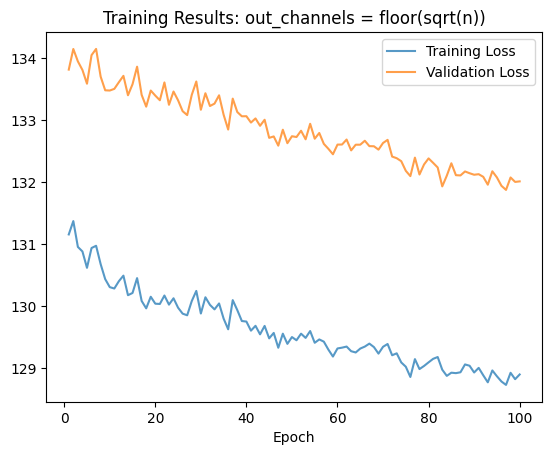

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 105.4265, Validation Loss (MSE): 106.4192
Epoch: 020, Training Loss (MSE): 105.4654, Validation Loss (MSE): 106.5021
Epoch: 030, Training Loss (MSE): 105.6023, Validation Loss (MSE): 106.5002
Epoch: 040, Training Loss (MSE): 105.3991, Validation Loss (MSE): 106.3240
Epoch: 050, Training Loss (MSE): 105.2696, Validation Loss (MSE): 106.1681
Epoch: 060, Training Loss (MSE): 105.4127, Validation Loss (MSE): 106.3060
Epoch: 070, Training Loss (MSE): 105.3175, Validation Loss (MSE): 106.1813
Epoch: 080, Training Loss (MSE): 105.6204, Validation Loss (MSE): 106.4783
Epoch: 090, Training Loss (MSE): 105.3232, Validation Loss (MSE): 106.1643
Best Epoch: 078, Test Loss (MSE): 106.355888


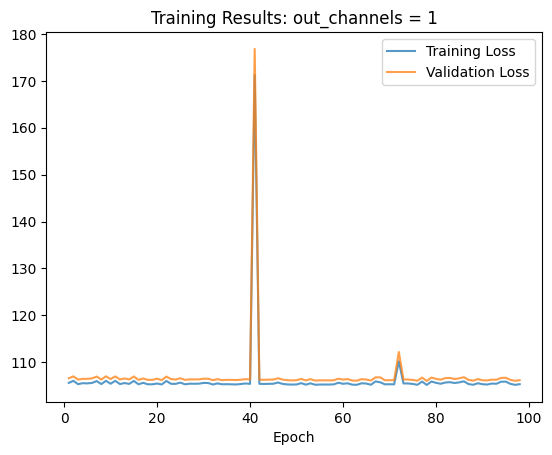

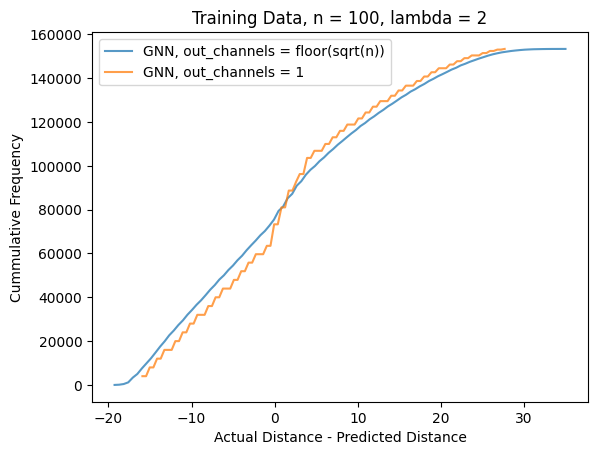

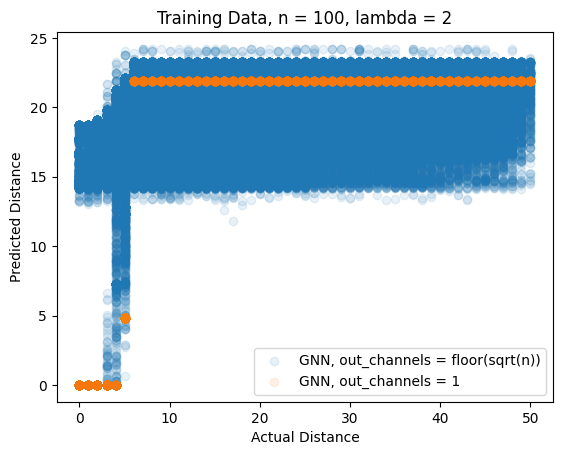

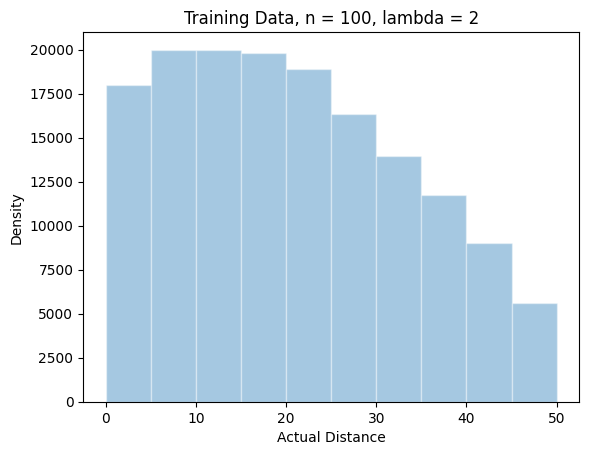

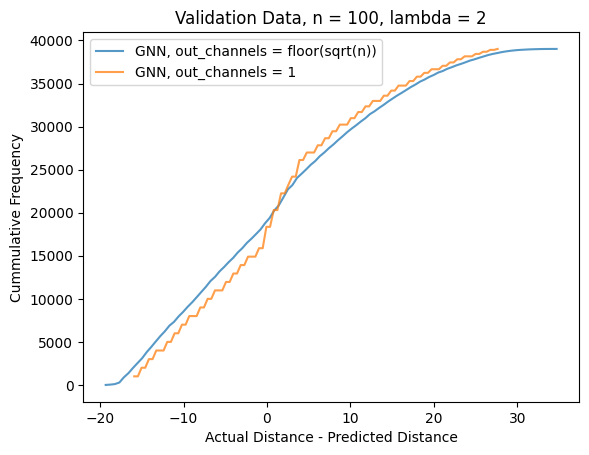

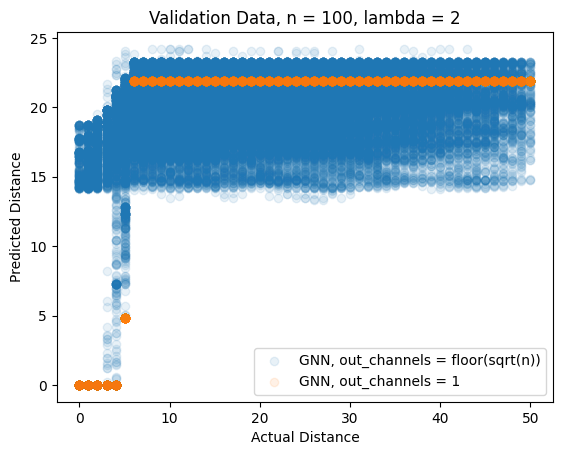

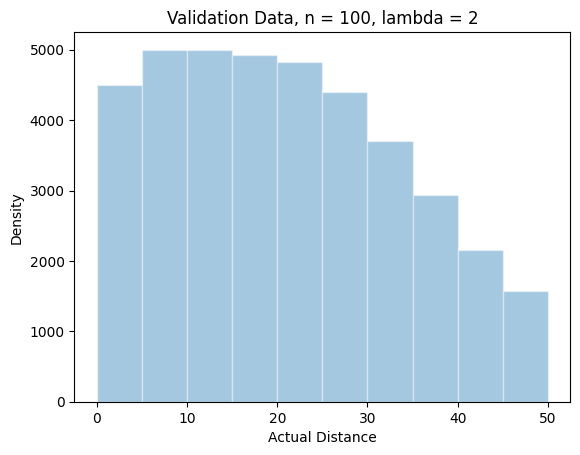

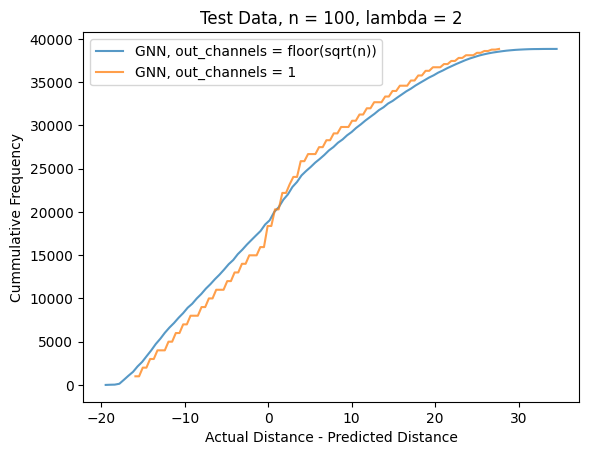

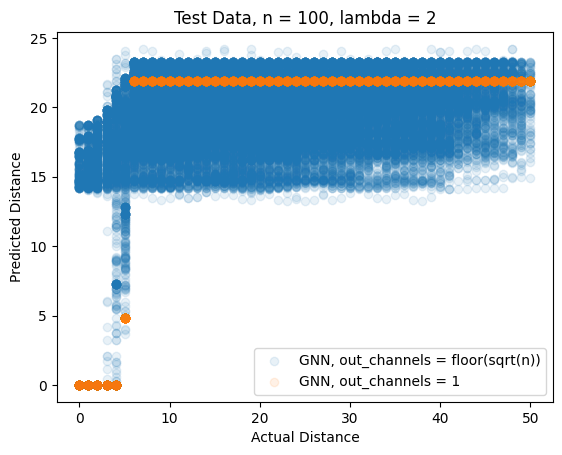

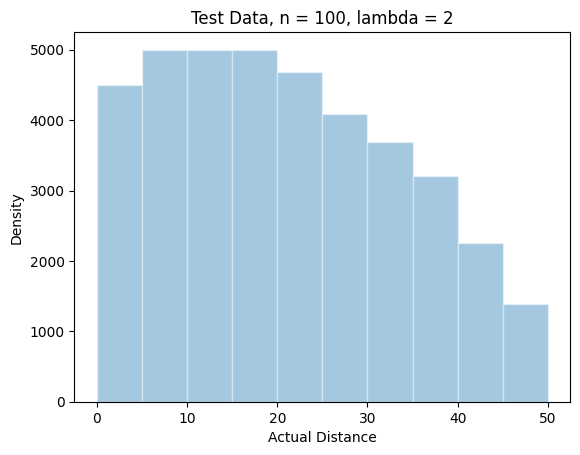

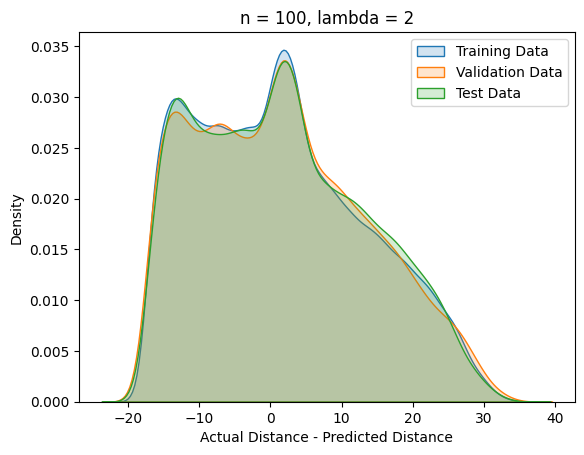

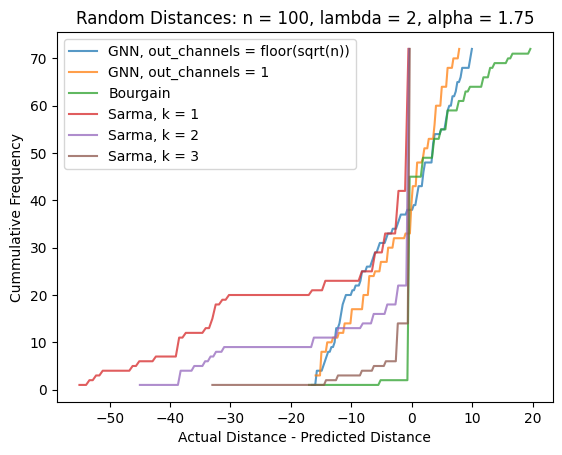

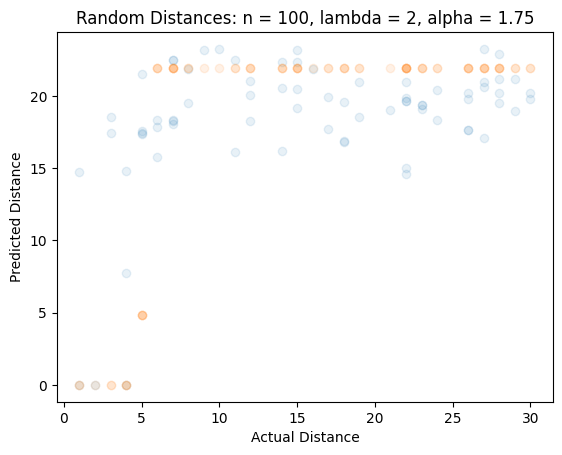

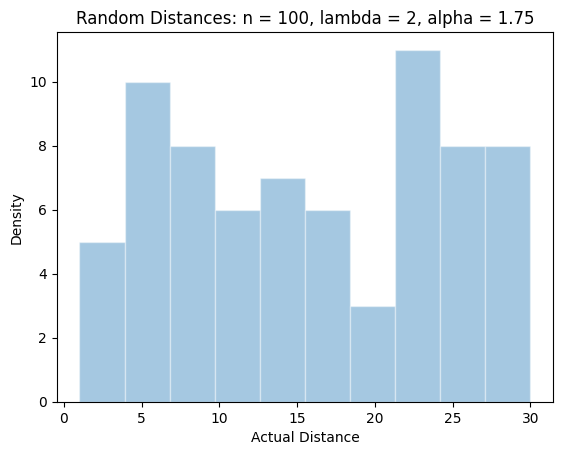

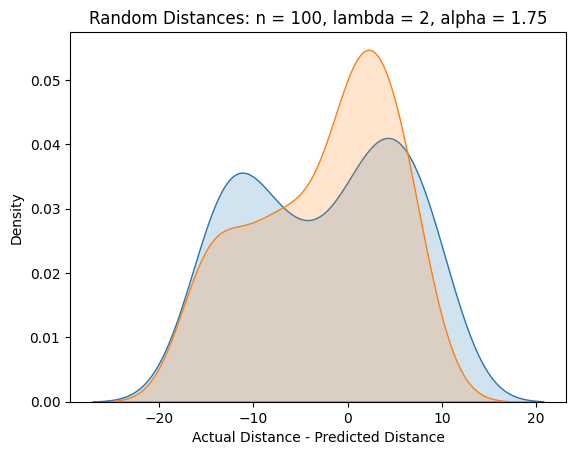

GNN, out_channels = floor(sqrt(n)), MSE: 74.1478405641772
GNN, out_channels = 1, MSE: 59.14516645911822
Bourgain, MSE: 38.125
Sarma, k = 1, MSE: 464.94444444444446
Sarma, k = 2, MSE: 178.70833333333334
Sarma, k = 3, MSE: 21.90277777777778
0


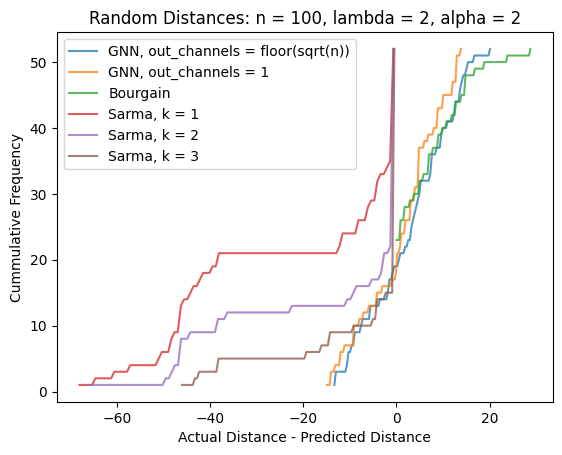

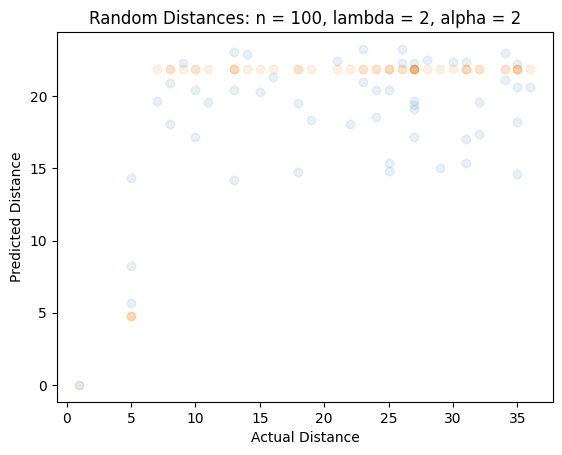

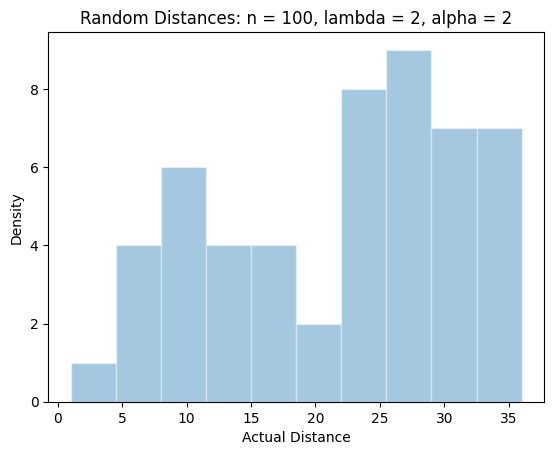

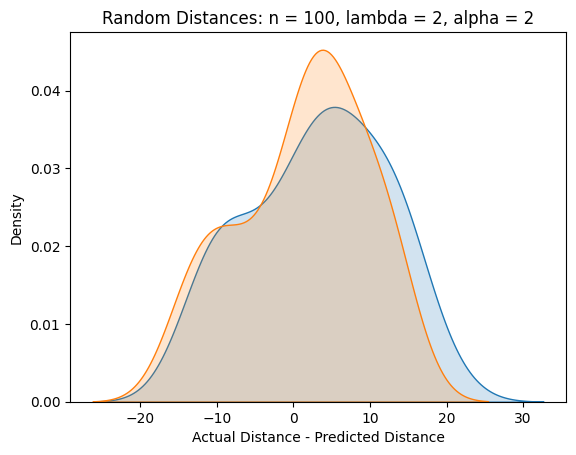

GNN, out_channels = floor(sqrt(n)), MSE: 88.75750479020105
GNN, out_channels = 1, MSE: 69.47281011281044
Bourgain, MSE: 79.53846153846153
Sarma, k = 1, MSE: 967.0769230769231
Sarma, k = 2, MSE: 512.1153846153846
Sarma, k = 3, MSE: 188.15384615384616
0


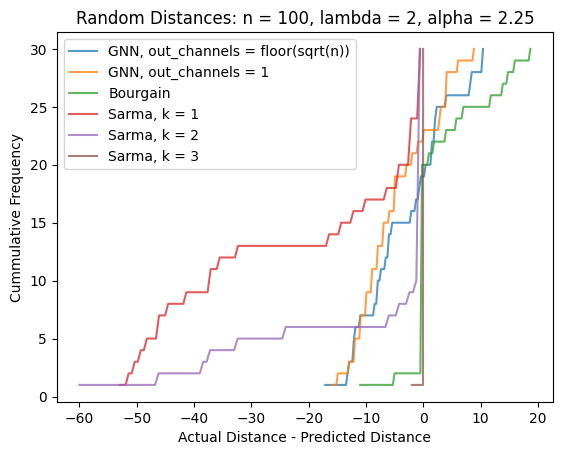

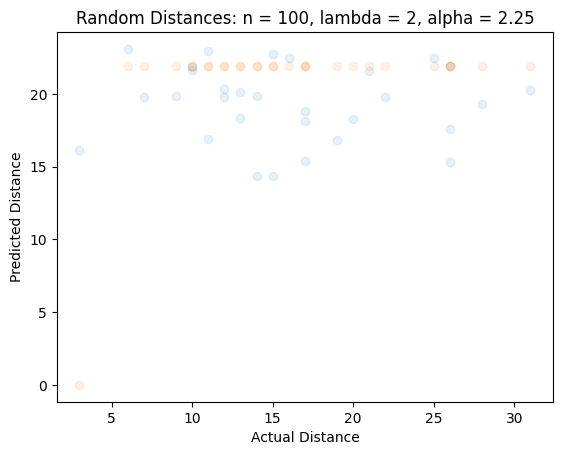

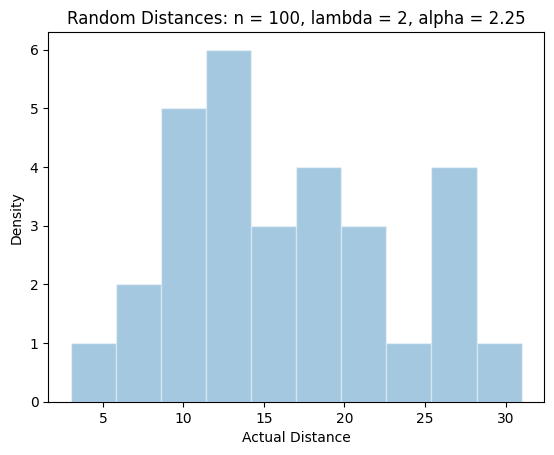

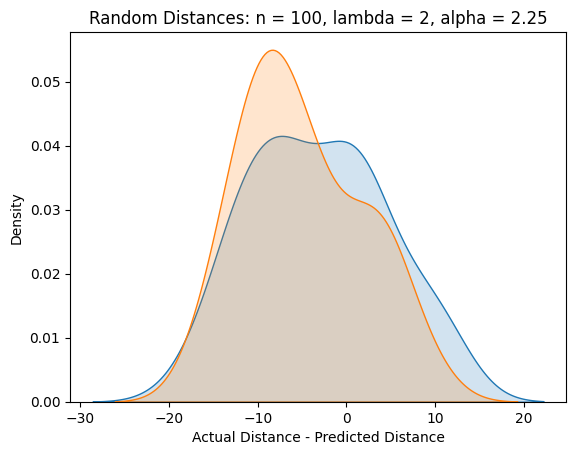

GNN, out_channels = floor(sqrt(n)), MSE: 65.51078259382851
GNN, out_channels = 1, MSE: 68.25529730185772
Bourgain, MSE: 47.8
Sarma, k = 1, MSE: 874.3666666666667
Sarma, k = 2, MSE: 339.53333333333336
Sarma, k = 3, MSE: 0.13333333333333333
0
100 4
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(10, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 10)
  (reLU): ReLU()
)
Epoch: 010,

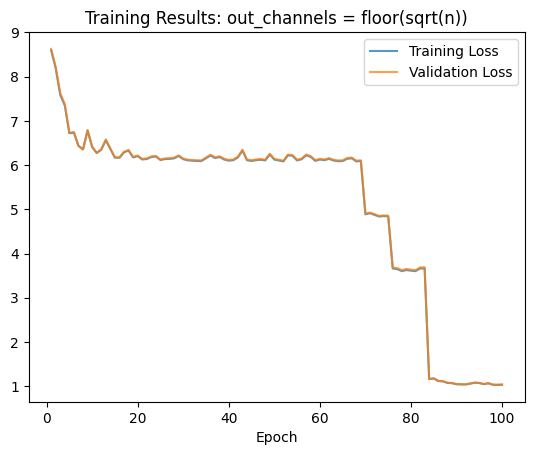

GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2646, Validation Loss (MSE): 0.2645
Epoch: 020, Training Loss (MSE): 0.1316, Validation Loss (MSE): 0.1307
Epoch: 030, Training Loss (MSE): 0.1247, Validation Loss (MSE): 0.1239
Epoch: 040, Training Loss (MSE): 0.1271, Validation Loss (MSE): 0.1262
Best Epoch: 024, Test Loss (MSE): 0.120545


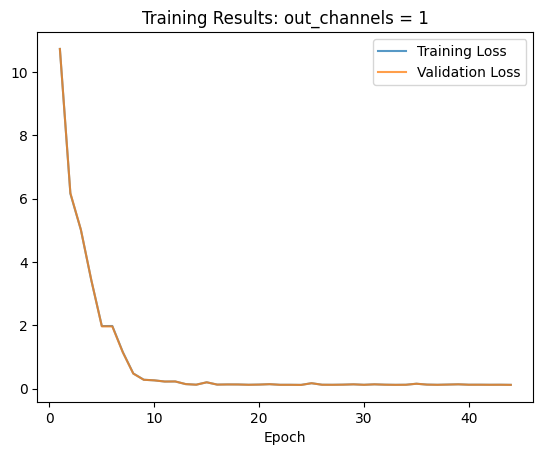

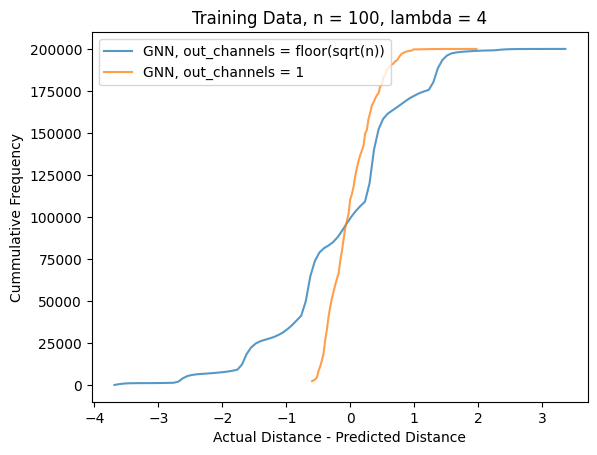

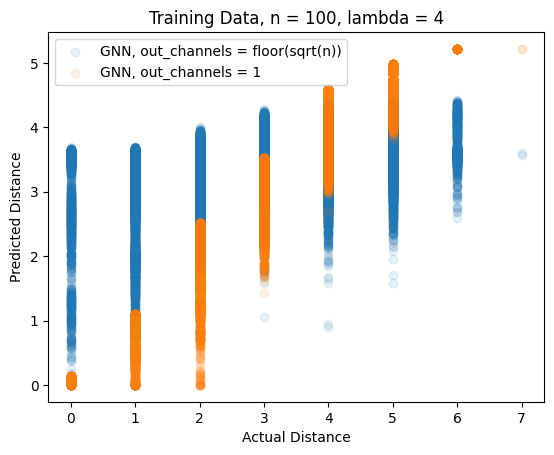

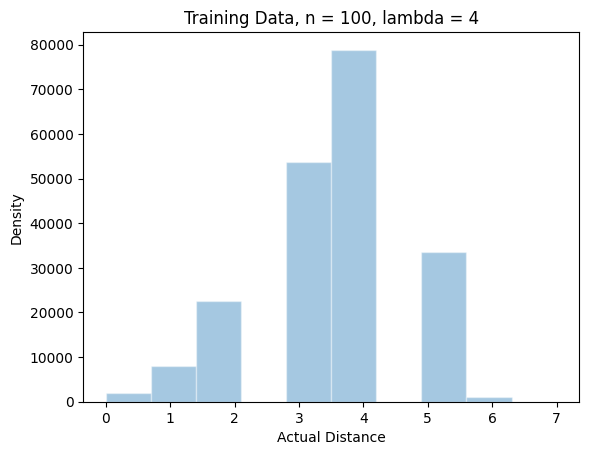

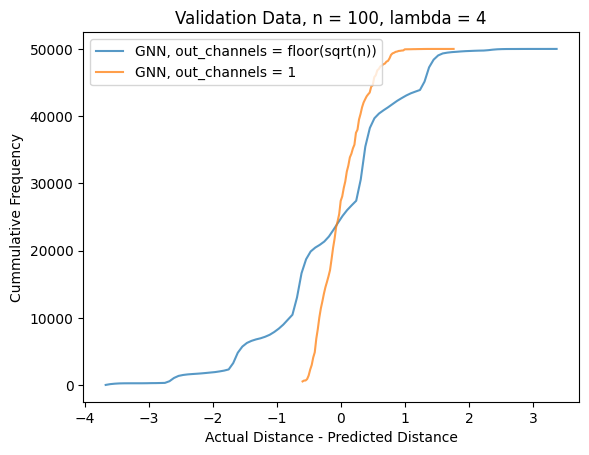

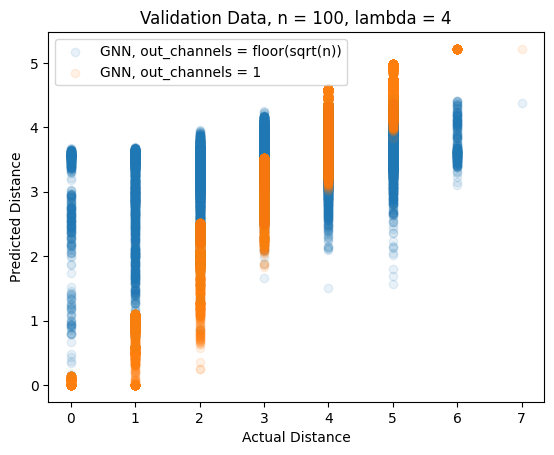

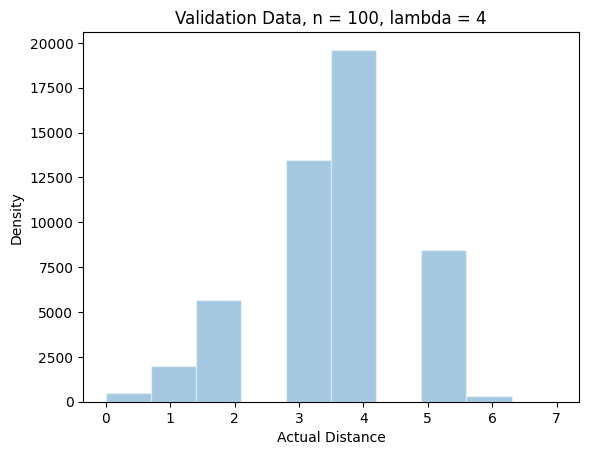

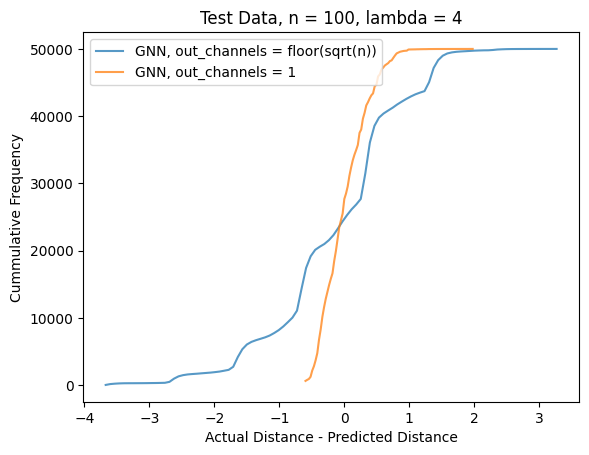

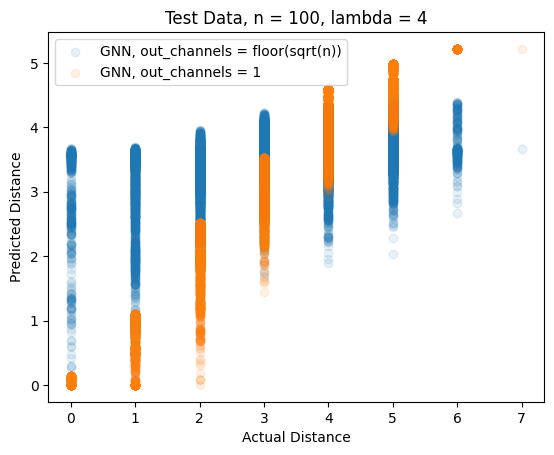

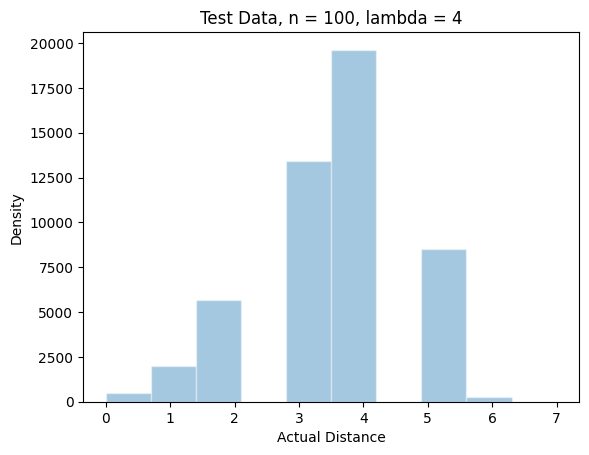

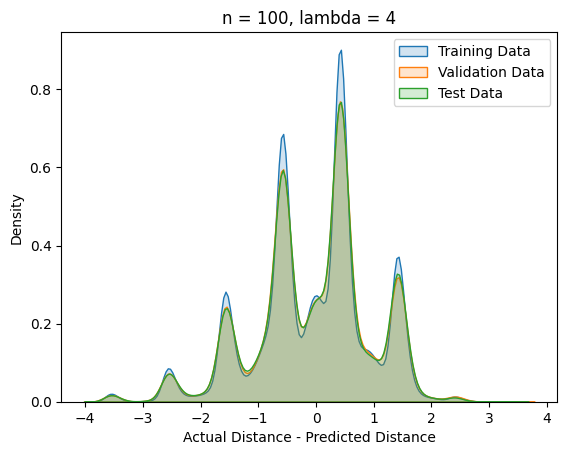

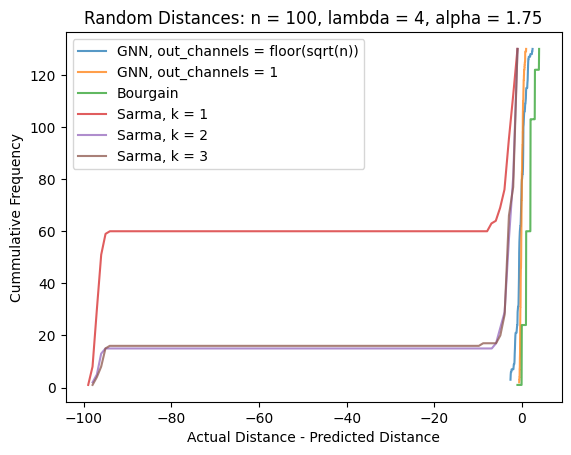

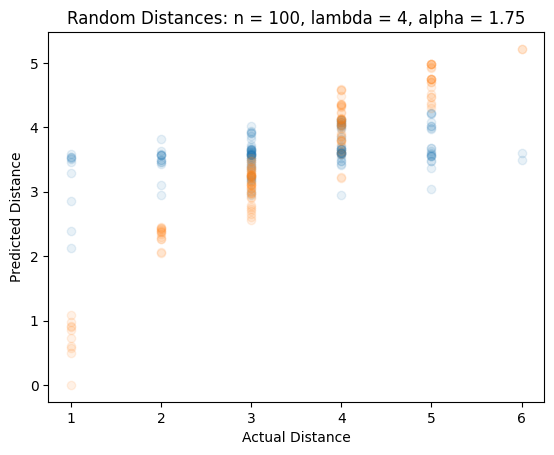

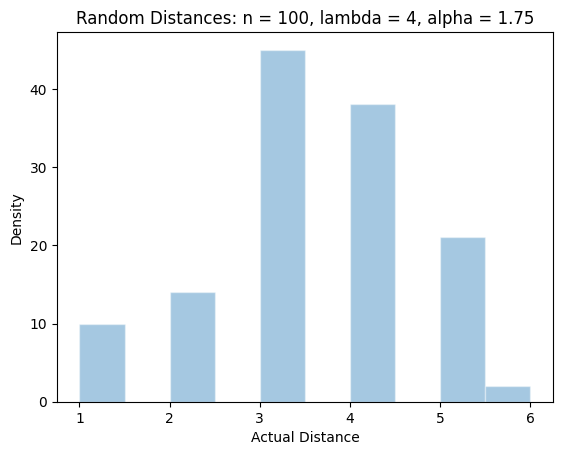

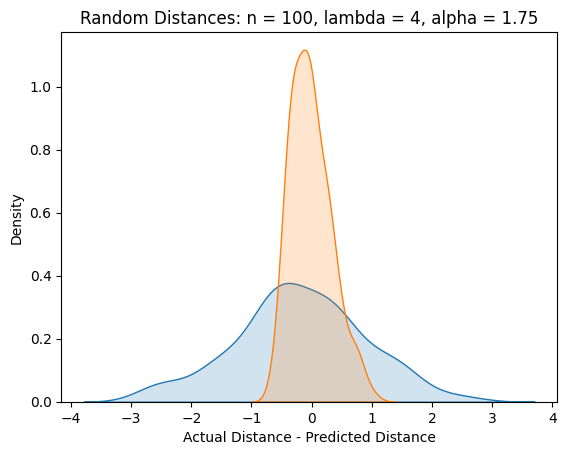

GNN, out_channels = floor(sqrt(n)), MSE: 1.157008234510575
GNN, out_channels = 1, MSE: 0.11295994679230235
Bourgain, MSE: 3.9076923076923076
Sarma, k = 1, MSE: 4299.753846153846
Sarma, k = 2, MSE: 1073.4538461538461
Sarma, k = 3, MSE: 1131.176923076923
0


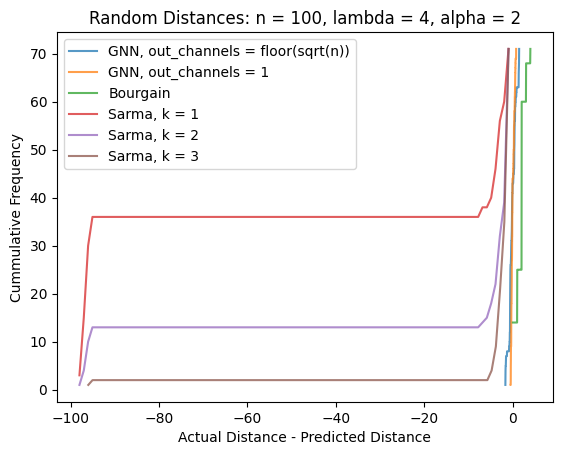

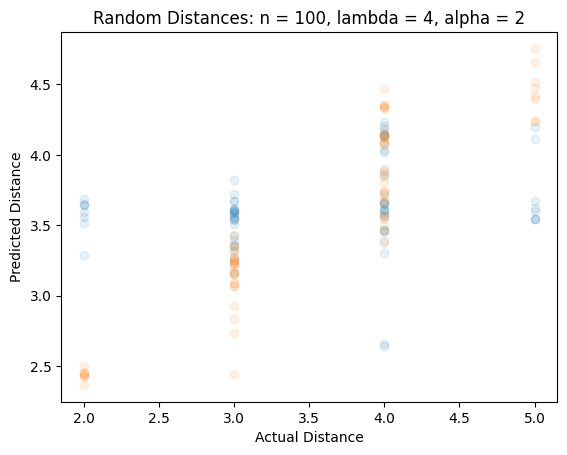

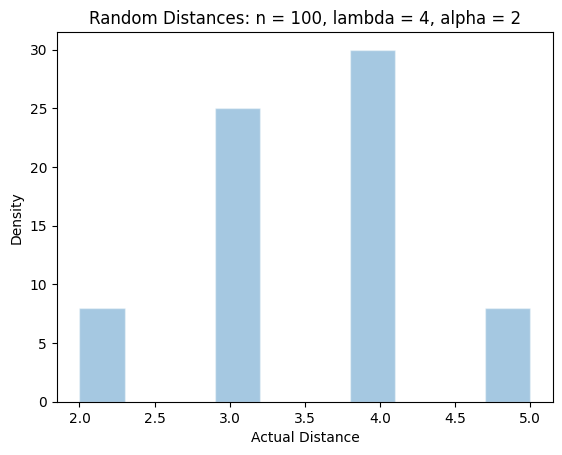

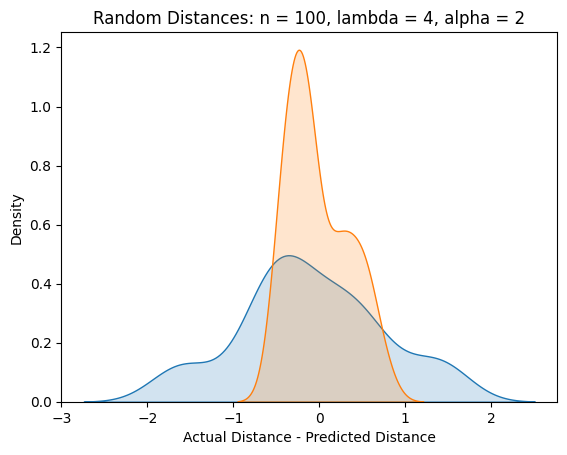

GNN, out_channels = floor(sqrt(n)), MSE: 0.6761774484838823
GNN, out_channels = 1, MSE: 0.1225213573451492
Bourgain, MSE: 3.816901408450704
Sarma, k = 1, MSE: 4708.619718309859
Sarma, k = 2, MSE: 1695.6901408450703
Sarma, k = 3, MSE: 258.8732394366197
0


In [10]:
N = 99
T = 100

mse1 = []
mse2 = []
graph_sizes = list(np.array(range(1,10))*10)+list(2**np.array(range(9))*100)
for n in list(2**np.array(range(9))*100):
    for lbd in [2,4,6]:
        model_dir = 'outputs2'
        dir = model_dir+'/lbd '+str(lbd)
        print(n,lbd)
        samples = generateSamples(200,50,50,dRegularGraph,n,lbd)
        model1 = run(samples,'gcn','mse','adam','cyclic-cosine',100,20,save_model=True)
        model2 = run_out1(samples,'gcn','mse','adam','cyclic-cosine',100,20,save_model=True)
        evaluate(n,model1,model2,'mse',samples)
        if n < T:
        #if n <= T:
            if n == 10:
                mselist1 = []
                durlist1 = []
            else:
                with open(model_dir+'/mse_'+str(lbd)+'.pkl', 'rb') as file:
                    mselist = pickle.load(file)
                with open(model_dir+'/dur_'+str(lbd)+'.pkl', 'rb') as file:
                    durlist = pickle.load(file)
            list1 = []
            list2 = []
            one_sample = generate_one_graph_all_distances(dRegularGraph,n,lbd)
            mse,dur = evaluate_one_graph_all_distances(n,model1,model2,'mse',one_sample,True)
            list1.append(mse)
            list2.append(dur)
            for k in range(99):
                if k % 10 == 0:
                    print(k)
                one_sample = generate_one_graph_all_distances(dRegularGraph,n,lbd)
                mse,dur = evaluate_one_graph_all_distances(n,model1,model2,'mse',one_sample)
                list1.append(mse)
                list2.append(dur)
            mselist.append(np.insert(np.mean(np.array(list1), axis=0), 0, n))
            durlist.append(np.insert(np.mean(np.array(list2), axis=0), 0, n))
            with open(model_dir+'/mse_'+str(lbd)+'.pkl', 'wb') as file:
                pickle.dump(mselist, file)
            with open(model_dir+'/dur_'+str(lbd)+'.pkl', 'wb') as file:
                pickle.dump(durlist, file)
        if n >= T:
            for alpha in [1.75,2,2.25]:
                file_path = model_dir+'/mse_'+str(lbd)+'_'+str(alpha)+'.pkl'
                if n == T or not os.path.exists(file_path):
                    mselist = []
                else:
                    with open(file_path) as file:
                        mselist = pickle.load(file)
                L = []
                graph_info = generate_one_graph(dRegularGraph,n,lbd)
                mse = evaluate_one_graph_random_distances(alpha,n,model1,model2,'mse',graph_info,True)
                L.append(mse)
                for k in range(9):
                    if k % 10 == 0:
                        print(k)
                    graph_info = generate_one_graph(dRegularGraph,n,lbd)
                    mse = evaluate_one_graph_random_distances(alpha,n,model1,model2,'mse',graph_info)
                    L.append(mse)
                mselist.append(np.insert(np.mean(np.array(L), axis=0), 0, n))
                with open(file_path, 'wb') as file:
                    pickle.dump(mselist, file)

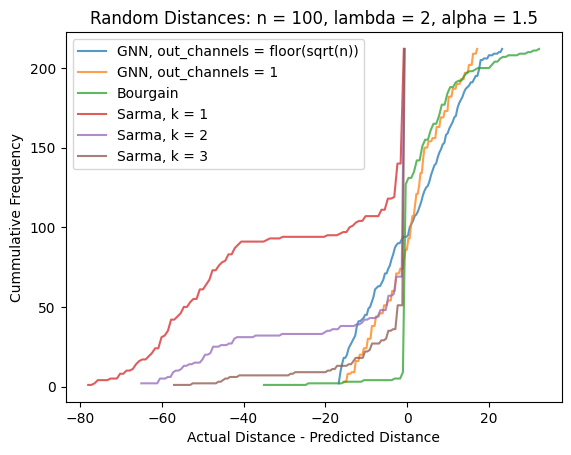

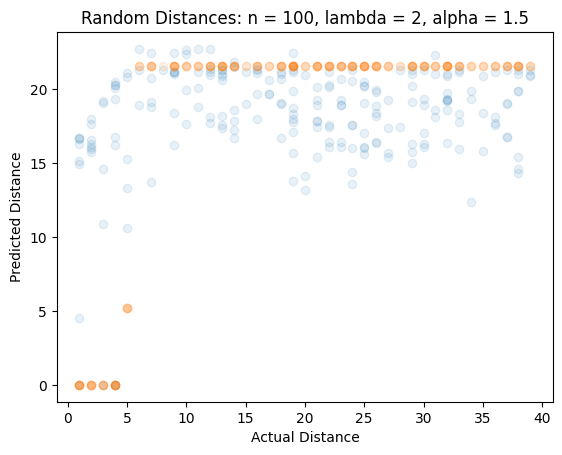

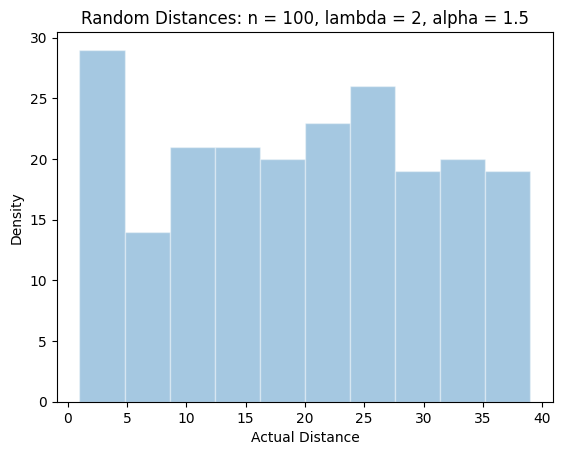

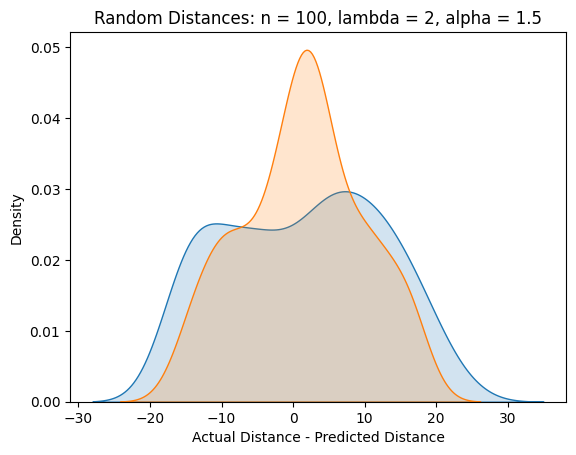

GNN, out_channels = floor(sqrt(n)), MSE: 122.36735127674221
GNN, out_channels = 1, MSE: 72.48706135725412
Bourgain, MSE: 72.16981132075472
Sarma, k = 1, MSE: 1367.877358490566
Sarma, k = 2, MSE: 419.14622641509436
Sarma, k = 3, MSE: 95.00471698113208
0


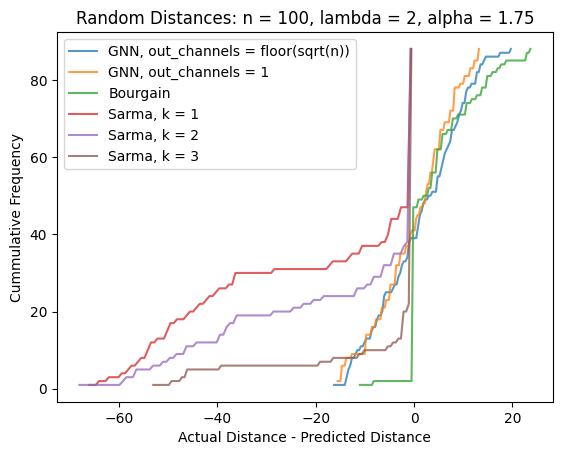

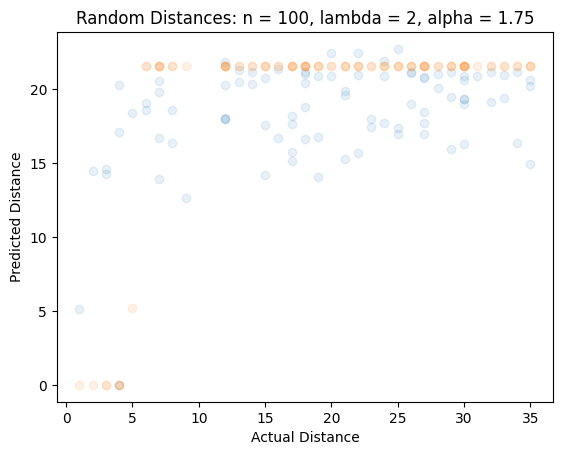

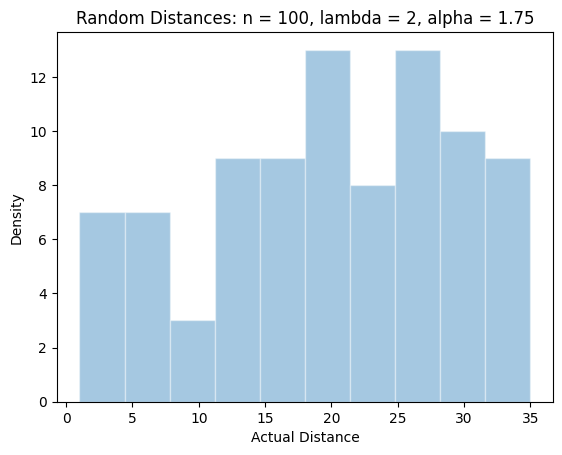

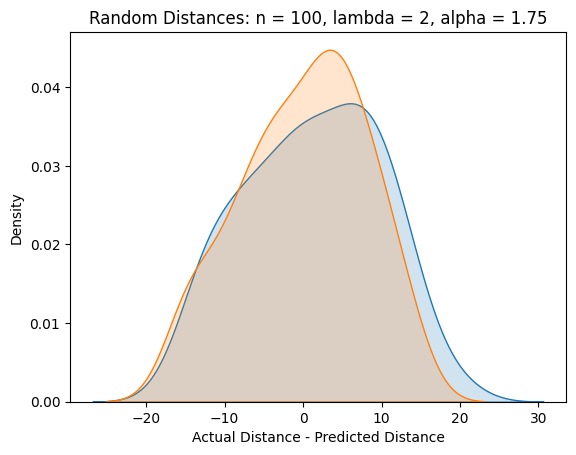

GNN, out_channels = floor(sqrt(n)), MSE: 75.22673646504084
GNN, out_channels = 1, MSE: 61.01993906853279
Bourgain, MSE: 62.45454545454545
Sarma, k = 1, MSE: 870.0454545454545
Sarma, k = 2, MSE: 535.2159090909091
Sarma, k = 3, MSE: 160.11363636363637
0


KeyboardInterrupt: 

In [11]:
n = 100
lbd = 2
model_dir = 'outputs2'
dir = 'outputs2/lbd '+str(lbd)
r = 10
T = 99
N = 99

model1,_,_,_ = build(r, r, 'gcn','mse','adam','cyclic-cosine')
model1.load_state_dict(torch.load(model_dir+'/model_out'+str(r)+'.pth'))
model2,_,_,_ = build(1, 1, 'gcn','mse','adam','cyclic-cosine')
model2.load_state_dict(torch.load(model_dir+'/model_out1.pth'))

for alpha in [1.75,2,2.25]:
    file_path = model_dir+'/mse_'+str(lbd)+'_'+str(alpha)+'.pkl'
    if n == T+1 or not os.path.exists(file_path):
        mselist = []
    else:
        with open(file_path) as file:
            mselist = pickle.load(file)
    L = []
    graph_info = generate_one_graph(dRegularGraph,n,lbd)
    mse = evaluate_one_graph_random_distances(alpha,n,model1,model2,'mse',graph_info,True)
    L.append(mse)
    for k in range(9):
        if k % 10 == 0:
            print(k)
        graph_info = generate_one_graph(dRegularGraph,n,lbd)
        mse = evaluate_one_graph_random_distances(alpha,n,model1,model2,'mse',graph_info)
        L.append(mse)
    mselist.append(np.insert(np.mean(np.array(L), axis=0), 0, n))
    with open(file_path, 'wb') as file:
        pickle.dump(mselist, file)

In [ ]:
def allShortestDistances_directed(i,j,d_ki,d_ij,d_jk): ## assume i,j in all shortest paths
    n = len(d_ki)
    distances =  np.zeros((n,n))
    for u in range(n):
        for v in range(n):
            if u != v:
                distances[u,v] = d_ki[u]+d_ij+d_jk[v]
    distances[i,j] = min(distances[i,j],d_ij)
    return distances

def allShortestDistances_undirected(i,j,d_ki,d_jk):
    if i == j:
        d_ij = 0
    else:
        d_ij = min(d_ki[j],d_jk[i])
    n = len(d_ki)
    distances =  np.zeros((n,n))
    for u in range(n):
        for v in range(u+1,n):
            distances[u,v] = min(d_ki[u]+d_ki[v],d_jk[u]+d_jk[v],d_ki[u]+d_ij+d_jk[v],d_ki[v]+d_ij+d_jk[u])
            distances[v,u] = distances[u,v]
    distances[i,j] = min(distances[i,j],d_ij)
    distances[j,i] = distances[i,j]
    return distances

def ShortestPath(G,distances,u,v,epsilon):
    S = [u,v]
    for k in range(distances.shape[0]):
        if np.abs(distances[u,k]+distances[k,v]-distances[u,v]) <= epsilon:
            S.append(k)
    S.sort()
    if not isinstance(G, np.ndarray):
        subgraph = G.subgraph(S)
        if nx.has_path(subgraph, u, v):
            if 'weight' in subgraph.graph:
                path = nx.shortest_path(subgraph, u, v, weight='weight')
                distance = nx.shortest_path_length(subgraph, u, v, weight='weight')
            else:
                path = nx.shortest_path(subgraph, u, v)
                distance = nx.shortest_path_length(subgraph, u, v)
            return path, distance
        else:
            return None, None
    else:
        subgraph = G[S]
        subgraph = subgraph[:,S]
        subgraph = matrix_to_graph(subgraph)
        u_masked = S.index(u)
        v_masked = S.index(v)
        if nx.has_path(subgraph, u_masked, v_masked):
            if 'weight' in subgraph.graph:
                path = nx.shortest_path(subgraph, u_masked, v_masked, weight='weight')
                distance = nx.shortest_path_length(subgraph, u_masked, v_masked, weight='weight')
            else:
                path = nx.shortest_path(subgraph, u_masked, v_masked)
                distance = nx.shortest_path_length(subgraph, u_masked, v_masked)
            return [S[i] for i in path], distance
        else:
            return None, None

In [ ]:
## Sarma claimed that there is at least one common node in SKETCH[u] and SKETCH[v] for undirected connected graphs. This is FALSE!!
import numpy as np
def checkSarmaAssumption(n,k):
    r = int(np.floor(np.log(n))) ## which base? use e instead of 10 this time since it returns a higher r, lowering the possibility of having no common nodes.
    seed_sizes = 2**np.array(list(range(r+1))*k)
    max_nodes_to_considered = (np.sum(seed_sizes)+1)*2
    boolean = n>max_nodes_to_considered
    return boolean
k1 = []
k2 = []
k3 = []
for n in range(1,100000):
    k1.append(checkSarmaAssumption(n,1))
    k2.append(checkSarmaAssumption(n,2))
    k3.append(checkSarmaAssumption(n,3))
print(np.sum(k1))
print(np.sum(k2))
print(np.sum(k3))